# Import Libraries

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2

import itertools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

import sklearn
import seaborn as sns
from sklearn.metrics import classification_report

# Clone & Explore dataset

In [6]:
#clone the dataset from the github repository
! git clone https://github.com/education454/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 2301, done.
remote: Total 2301 (delta 0), reused 0 (delta 0), pack-reused 2301
Receiving objects: 100% (2301/2301), 1.31 GiB | 21.60 MiB/s, done.
Checking out files: 100% (2295/2295), done.


In [7]:
root_path = '/content/datasets/Data'

train_path = '/content/datasets/Data/train'

test_path = '/content/datasets/Data/test'

train_cov = os.path.join(train_path, 'COVID19')

train_normal = os.path.join(train_path, 'NORMAL')

test_cov = os.path.join(test_path, 'COVID19')

test_normal = os.path.join(test_path, 'NORMAL')

In [8]:
train_covid_filenames = os.listdir(train_cov)
train_normal_filenames = os.listdir(train_normal)

total_train = len(train_covid_filenames+train_normal_filenames)

test_covid_filenames = os.listdir(test_cov)
test_normal_filenames = os.listdir(test_normal)

total_test = len(test_covid_filenames+test_normal_filenames)

In [9]:
print('Total train images: %d' %(total_train))
print('Total test images: %d' %(total_test))
print('Total data samples: %d' %((total_train + total_test)))

Total train images: 1811
Total test images: 484
Total data samples: 2295


#Data Visualization

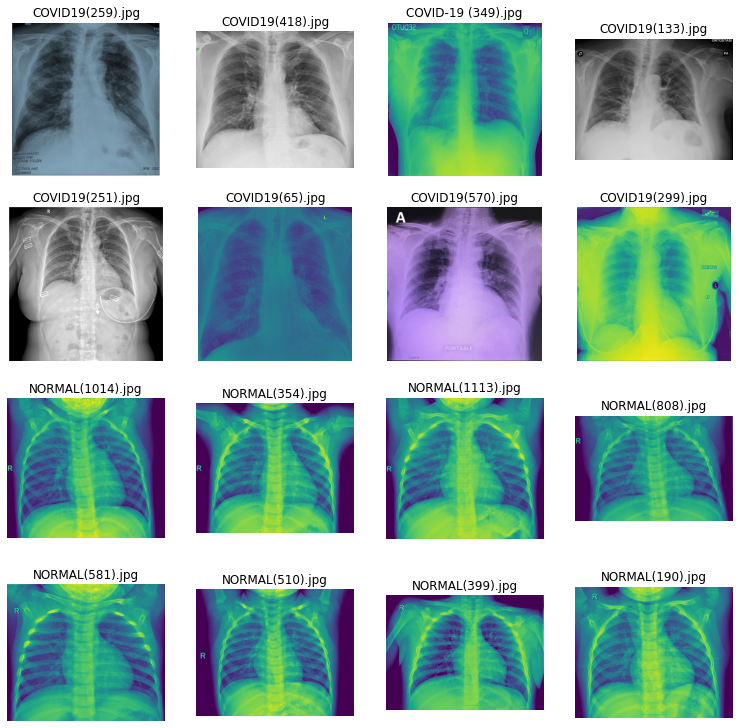

In [10]:
rows, columns = 4,4
figure = plt.gcf()
figure.set_size_inches(13,13)

covid = [os.path.join(train_cov, filename) for filename in train_covid_filenames[12:20]]
normal = [os.path.join(train_normal, filename) for filename in train_normal_filenames[12:20]]

examples = covid + normal

for each, path in enumerate(covid + normal):
  data = path.split('/',6)[6]
  sep = plt.subplot(rows,columns, each + 1)
  sep.axis('Off')
  image = mpimg.imread(path)
  sep.set_title(data, fontsize = 12)
  plt.imshow(image) 

#Data Preprocessing & Augmentation

In [11]:
train_generator = ImageDataGenerator(rescale=1 / 255.0,
                                     validation_split = 0.2,
                                     zoom_range = 0.1,
                                     rotation_range = 12)
test_generator = ImageDataGenerator(rescale=1/255.0)

train_data = train_generator.flow_from_directory(train_path,
                                                 target_size = (224,224),
                                                 subset = 'training',
                                                 batch_size = 64,
                                                 class_mode = 'binary')

validation_data = train_generator.flow_from_directory(train_path,
                                                 target_size = (224,224),
                                                 batch_size = 64,
                                                 subset = 'validation',
                                                 class_mode = 'binary')

test_data = test_generator.flow_from_directory(test_path,
                                                 target_size = (224,224),
                                                 batch_size = 1,
                                                 class_mode = 'binary',
                                                 shuffle = False)

Found 1449 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


In [12]:
train_data.class_indices

{'COVID19': 0, 'NORMAL': 1}

In [13]:
train_data.image_shape

(224, 224, 3)

#Build Model

In [26]:
resnet_base = ResNet50V2(include_top=False, weights = 'imagenet', input_shape=(224,224,3))
for layer in resnet_base.layers:
  layer.trainable = False

#resnet_base.summary()  

In [31]:
resnet_out = resnet_base.get_layer('conv5_block1_2_bn').output
x = Conv2D(512, (3,3), activation= tf.keras.layers.LeakyReLU(alpha = 0.21),padding = 'same')(resnet_out)
x = BatchNormalization(momentum=0.9)(x)
x = MaxPooling2D((2,2),padding = 'same')(x)

x = Conv2D(512, (3,3), activation= tf.keras.layers.LeakyReLU(alpha = 0.21), padding = 'same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = MaxPooling2D((2,2),padding = 'same')(x)

x = Conv2D(512, (3,3), activation= tf.keras.layers.LeakyReLU(alpha = 0.21),padding = 'same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = MaxPooling2D((2,2),padding = 'same')(x)

x = Flatten()(x)
x = Dense(784, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = Dense(256, activation = 'relu')(x)
out_layer = Dense(1, activation='sigmoid')(x) # or 2 with softmax

last_model = tf.keras.models.Model(inputs = resnet_base.input,
                                   outputs = out_layer)
last_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

#Compile & Train the Model

In [32]:
last_model.compile(loss = 'binary_crossentropy', 
                   optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                   metrics = ['accuracy'])

In [33]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience= 3, verbose = 1)
lr_sch = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience= 2,
                                              factor = np.sqrt(0.2), verbose = 1,
                                              min_lr = 5e-10)

history = last_model.fit(train_data, epochs = 24, 
                         validation_data=validation_data,
                         batch_size = 64, callbacks = [es, lr_sch])

Epoch 1/24
23/23 [==============================] - 58s 2s/step - loss: 0.2374 - accuracy: 0.8859 - val_loss: 0.0251 - val_accuracy: 0.9945
Epoch 2/24
23/23 [==============================] - 53s 2s/step - loss: 0.0160 - accuracy: 0.9960 - val_loss: 0.1038 - val_accuracy: 0.9530
Epoch 3/24
23/23 [==============================] - 53s 2s/step - loss: 0.0126 - accuracy: 0.9952 - val_loss: 0.0507 - val_accuracy: 0.9834

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.472135842023922e-05.
Epoch 4/24
23/23 [==============================] - 53s 2s/step - loss: 0.0212 - accuracy: 0.9945 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 5/24
23/23 [==============================] - 53s 2s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9945
Epoch 6/24
23/23 [==============================] - 53s 2s/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0033 - val_accuracy: 0.9972
Epoch 7/24
23/23 [==============================] - 53s 2s/step - loss: 0.0033 

# Performance Evaluation

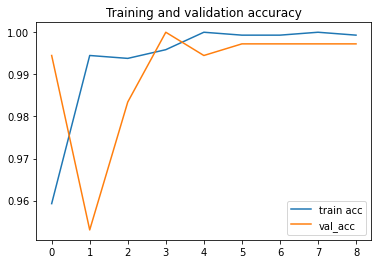

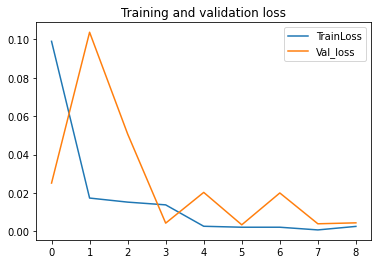

In [34]:
# %% Check Plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs,acc, label = 'train acc' )
plt.plot(epochs, val_acc, label = 'val_acc' )
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy Graph')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot( epochs, loss, label = 'TrainLoss' )
plt.plot(epochs, val_loss, label = 'Val_loss' )
plt.title('Training and validation loss'   )
plt.savefig('Loss Graph')
plt.legend()

plt.show()

In [36]:
filenames = test_data.filenames
nb_samples = len(filenames)
nb_samples

484

In [45]:
true_labels = test_data.classes

In [37]:
predict = last_model.predict(test_data,steps = nb_samples)

In [42]:
y_pred = [1 * (x[0]>=0.5) for x in predict]
y_pred[:10]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [46]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
 

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

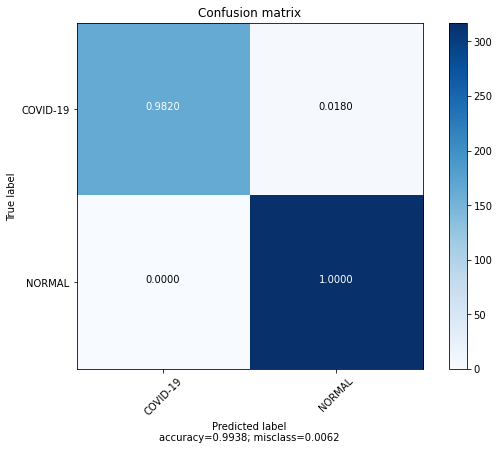

In [47]:
cm = sklearn.metrics.confusion_matrix(true_labels, y_pred)
target_names = ['COVID-19', 'NORMAL']
plot_confusion_matrix(cm,target_names)

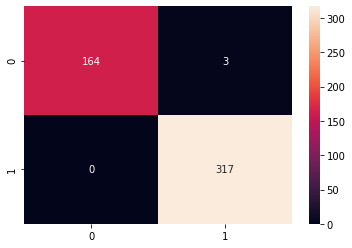

In [48]:
sns.heatmap(cm, annot = True, fmt = 'd')

In [50]:
print(classification_report(true_labels, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    COVID-19       1.00      0.98      0.99       167
      NORMAL       0.99      1.00      1.00       317

    accuracy                           0.99       484
   macro avg       1.00      0.99      0.99       484
weighted avg       0.99      0.99      0.99       484

